# Clustering Documents Tweets

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

http://adilmoujahid.com/posts/2014/07/twitter-analytics/

https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/



In [1]:
import codecs
import glob
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import time

from math import log
from matplotlib import pyplot as plt
from nltk import sent_tokenize, word_tokenize
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy import ndimage
from sklearn import manifold, datasets
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

%matplotlib inline
#nltk.download()

In [2]:
path_prep_files = 'Streaming/' #iot_results.json
all_files =  glob.glob(path_prep_files+'*.txt')
print (all_files)
token_arr = []
path = 'Streaming/'

['Streaming\\iot_data_130516.txt', 'Streaming\\iot_data_140516.txt', 'Streaming\\iot_data_150516.txt', 'Streaming\\iot_data_160516.txt', 'Streaming\\iot_data_170516.txt', 'Streaming\\iot_data_180516.txt']


In [3]:
tokens_list = []

regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

regex_rem = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
tokens_remove = re.compile(r'('+'|'.join(regex_rem)+')', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

def tokenize(s):
    '''tokens = nltk.word_tokenize(text)
    return tokens'''
    return tokens_re.findall(s)
          
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens         

counter = 0

In [4]:
print(tokens_list)
counter2 = 0

with open(path+'iot_data_160516.txt', 'r') as f:
    for line in f:
        counter+=1
        if counter == 2000:
            break;
        tweet = json.loads(line)
        tweetString = ""
        for term in preprocess(tweet['text']):
            if not tokens_remove.search(term) and term not in stop:
                tweetString = tweetString + term + " "
        tokens_list.append(tweetString)


'''tokens_list = tokens_list + [term for term in preprocess(tweet['text']) if term not in stop]'''
print counter
'''print tokens_list_clr'''

tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
print tfidf
print tfidf.idf_
print tfs


[]
2000
Dimensiones tf-idf (1999, 1490)
TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=2,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
[ 7.50229017  6.65499231  7.50229017 ...,  7.50229017  7.50229017
  7.50229017]
  (0, 87)	0.501898312092
  (0, 311)	0.497804969396
  (0, 1109)	0.498383768881
  (0, 1022)	0.501898312092
  (1, 1464)	0.519781773664
  (1, 496)	0.57269375854
  (1, 1460)	0.550733300656
  (1, 43)	0.313913361047
  (2, 173)	0.333981443979
  (2, 629)	0.561461419186
  (2, 320)	0.366816718451
  (2, 559)	0.662316363159
  (3, 87)	0.501898312092
  (3, 311)	0.497804969396
  (3, 1109)	0.498383768881
  (3, 1022)	0.501898312092
  (4, 6

### Identify best K

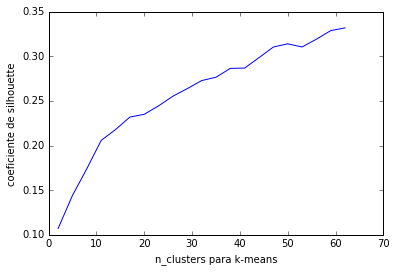

In [5]:
k_range = range(2,65,3)

start = time()
# Fit the kmeans model for each n_clusters = k

k_means_var = [KMeans(init='k-means++', n_clusters=k, n_init=10, n_jobs=-1).fit(tfs) for k in k_range]
Res_Silhouette=[metrics.silhouette_score(tfs, cluster.labels_, sample_size=15000) for cluster in k_means_var]
%matplotlib inline 
plt.plot(k_range, Res_Silhouette,"-")
plt.xlabel("n_clusters para k-means")
plt.ylabel("coeficiente de silhouette")
plt.show()

C:\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


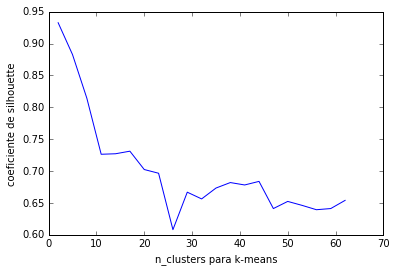

In [6]:
k_range = range(2,65,3)
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
reduced_data = lsa.fit_transform(tfs)

start = time()
# Fit the kmeans model for each n_clusters = k

k_means_var = [KMeans(init='k-means++', n_clusters=k, n_init=10, n_jobs=-1).fit(reduced_data) for k in k_range]
Res_Silhouette=[metrics.silhouette_score(reduced_data, cluster.labels_, sample_size=15000) for cluster in k_means_var]
%matplotlib inline 
plt.plot(k_range, Res_Silhouette,"-")
plt.xlabel("n_clusters para k-means")
plt.ylabel("coeficiente de silhouette")
plt.show()

### Graphics



In [7]:
t0 = time()
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

reduced_data = lsa.fit_transform(tfs)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

t0 = time()
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, n_jobs=1)

print(reduced_data)
kmeans.fit(tfs)
kmeans.fit(reduced_data)
print("done in %0.3fs" % (time() - t0))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced_data, kmeans.labels_, sample_size=15000))


done in 0.028000s
Explained variance of the SVD step: 14%
[[ 0.99995321 -0.00967404]
 [ 0.03230143  0.99947817]
 [ 0.01002995  0.9999497 ]
 ..., 
 [ 0.11501733  0.99336348]
 [ 0.01335926  0.99991076]
 [ 0.0093075   0.99995668]]
done in 1.804s
Silhouette Coefficient: 0.768


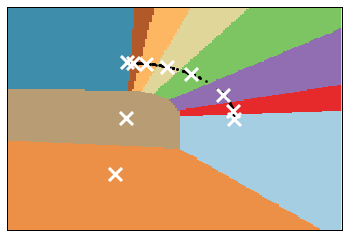

Hallo


In [8]:
x_min, x_max = reduced_data[:, 0].min()-1, reduced_data[:, 0].max()+1
y_min, y_max = reduced_data[:, 1].min()-1, reduced_data[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=4)
centroids = kmeans.cluster_centers_
inert = kmeans.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
print ("Hallo")